In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn


# Class to generate and analyze colored noise
class GenerateNoise:
    def __init__(self, sample_rate, t_max, relative_PSD_strength, num_realizations, ifwhite=True, fmin=0.):
        """
        Initialize the noise generator with parameters.
        
        Parameters:
        -----------
        sample_rate : float
            Sampling rate in 1/ns
        t_max : int
            Maximum time in number of samples
        relative_PSD_strength : float
            Target PSD strength at f→0
        num_realizations : int
            Number of noise realizations to generate
        ifwhite : bool, optional
            If True, generates white noise, otherwise 1/f noise. Default is True.
        fmin : float, optional
            Minimum frequency, default is 0
        """
        self.sample_rate = sample_rate
        self.t_max = t_max
        self.dt = 1/sample_rate
        self.relative_PSD_strength = relative_PSD_strength
        self.num_realizations = num_realizations
        self.ifwhite = ifwhite
        self.fmin = fmin
        self.N = self.t_max * self.sample_rate
        self.noise_type = "White Noise" if self.ifwhite else "1/f Noise"
        
    def generate_colored_noise(self):
        """
        Generate realizations of 1/f^alpha noise based on initialized parameters.
        Returns array of shape (num_realizations, N).
        """
        alpha = 0 if self.ifwhite else 1

        # For white noise, directly scale with the target PSD strength
        return np.array([
            cn.powerlaw_psd_gaussian(alpha, self.N, fmin=self.fmin)
            for _ in range(self.num_realizations)
        ]) * np.sqrt(self.relative_PSD_strength * self.sample_rate)
    def analyze_noise_psd(self, trajectories):
        """
        Analyze noise trajectories: compute PSD, plot it, and perform sanity checks.
        
        Parameters:
        -----------
        trajectories : ndarray
            Noise trajectories of shape (num_realizations, num_samples)
        
        Returns:
        --------
        dict
            Dictionary containing computed values (freqs, avg_psd, median_ratio, std_ratio)
        """
        # Scale to target PSD at f→0

        # Compute raw periodograms
        freqs = np.fft.rfftfreq(self.N, d=self.dt)
        psds = np.abs(np.fft.rfft(trajectories, axis=1))**2 / self.sample_rate**2/ self.t_max
        # Average PSD
        avg_psd = psds.mean(axis=0)
        # Plot average PSD
        plt.figure(figsize=(7,5))
        plt.loglog(freqs, avg_psd, 'b', label='Measured PSD')
        plt.xlabel('Frequency [1/ns]')
        plt.ylabel('PSD [units^1/Hz]')
        plt.title(f'Average PSD of {self.noise_type}')
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Sanity checks
        # 1) Median raw periodogram / (S0 * t_max)
        median_ratio = np.median(avg_psd) / (self.relative_PSD_strength )
        # 2) Std dev of integrated phase / sqrt(S0 * t_max)
        phi = np.cumsum(trajectories * self.dt, axis=1)
        std_ratio = np.std(phi[:, -1]) / np.sqrt(self.relative_PSD_strength * self.t_max)

        print(f'Sanity Checks ({self.noise_type.lower()}):')
        if self.noise_type.lower() == 'white noise':
            print(f"Median raw periodogram / (S0 ): {median_ratio:.6f}")
            print(f"Std dev of integrated phase / sqrt(S0 * t_max): {std_ratio:.6f}")
        else:
            # Fit the PSD in log10 scale to get the slope (should be close to -1 for 1/f noise)
            # Skip the first few points to avoid DC component
            mask = freqs > 0  # Exclude zero frequency
            log_freqs = np.log10(freqs[mask])
            log_psd = np.log10(avg_psd[mask])
            
            # Linear regression to get slope and intercept
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_freqs, log_psd)
            
            # Calculate noise amplitude (10^slope)
            noise_amplitude = 10**intercept
            
            # Plot the fitting curve for 1/f noise
            fit_psd = 10**(slope * np.log10(freqs[mask]) + intercept)
            plt.loglog(freqs[mask], fit_psd, 'r--', label=f'Fit: 1/f^{-slope:.2f}')
            plt.legend()
            
            S0 = np.sqrt(noise_amplitude/(2*np.pi))
            print(f"PSD fit: power = {slope:.4f}, intercept = {intercept:.4f}, R² = {r_value**2:.4f}, S0 = {S0:.6e}")
        
        plt.tight_layout()
        plt.show()
            
        
    
    def run_analysis(self):
        """
        Generate and analyze noise trajectories with the initialized parameters.
        
        Returns:
        --------
        dict
            Dictionary containing analysis results
        """
        # Generate noise trajectories
        trajectories = self.generate_colored_noise()
        
        # Analyze the trajectories
        results = self.analyze_noise_psd(trajectories)
        
        return results

In [31]:
sample_rate = 1               # per ns
t_max = int(1e4)             # number of samples
relative_PSD_strength = (1e-2)**2
num_realizations = 1000
ifwhite = False             # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = t_max * sample_rate
gn = GenerateNoise(sample_rate, t_max, relative_PSD_strength, num_realizations, ifwhite)

Sanity Checks (1/f noise):
PSD fit: power = -1.0003, intercept = -5.2602, R² = 0.9990, S0 = 9.349437e-04


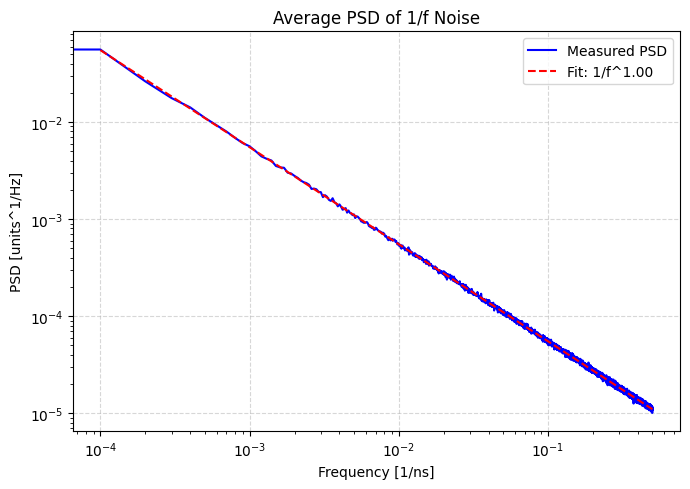

In [32]:
trajs = gn.generate_colored_noise()
gn.analyze_noise_psd(trajs)